# **Mobile App User Enrollment Prediction**

### This script analyzes user behavior in a mobile app to predict whether users will enroll
in a premium service within 48 hours of their first app open.

### Key Steps:
1. Exploratory Data Analysis (EDA)
2. Feature Engineering
3. Model Building and Evaluation
4. Model Tuning
5. Results Analysis

### 1. Import Libraries and Load Data


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import parser
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, accuracy_score, 
                           f1_score, precision_score, recall_score)
import time
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

### 2. Exploratory Data Analysis (EDA)

In [14]:
# Load dataset
dataset = pd.read_csv('appdata10.csv')

# Initial exploration
print("Dataset shape:", dataset.shape)
print("\nFirst 5 rows:")
print(dataset.head())
print("\nDescriptive statistics:")
print(dataset.describe())

Dataset shape: (50000, 12)

First 5 rows:
     user               first_open  dayofweek       hour  age  \
0  235136  2012-12-27 02:14:51.273          3   02:00:00   23   
1  333588  2012-12-02 01:16:00.905          6   01:00:00   24   
2  254414  2013-03-19 19:19:09.157          1   19:00:00   23   
3  234192  2013-07-05 16:08:46.354          4   16:00:00   28   
4   51549  2013-02-26 18:50:48.661          1   18:00:00   31   

                                         screen_list  numscreens  minigame  \
0  idscreen,joinscreen,Cycle,product_review,ScanP...          15         0   
1  joinscreen,product_review,product_review2,Scan...          13         0   
2                                  Splash,Cycle,Loan           3         0   
3  product_review,Home,product_review,Loan3,Finan...          40         0   
4  idscreen,joinscreen,Cycle,Credit3Container,Sca...          32         0   

   used_premium_feature  enrolled            enrolled_date  liked  
0                     0       

### 2.1 Data Cleaning and Feature Extraction

In [15]:
# Extract hour from time string
dataset["hour"] = dataset.hour.str.slice(1, 3).astype(int)

# Prepare dataset for visualization
viz_data = dataset.copy().drop(columns=['user', 'screen_list', 'enrolled_date', 'first_open'])

### 2.2 Data Visualization

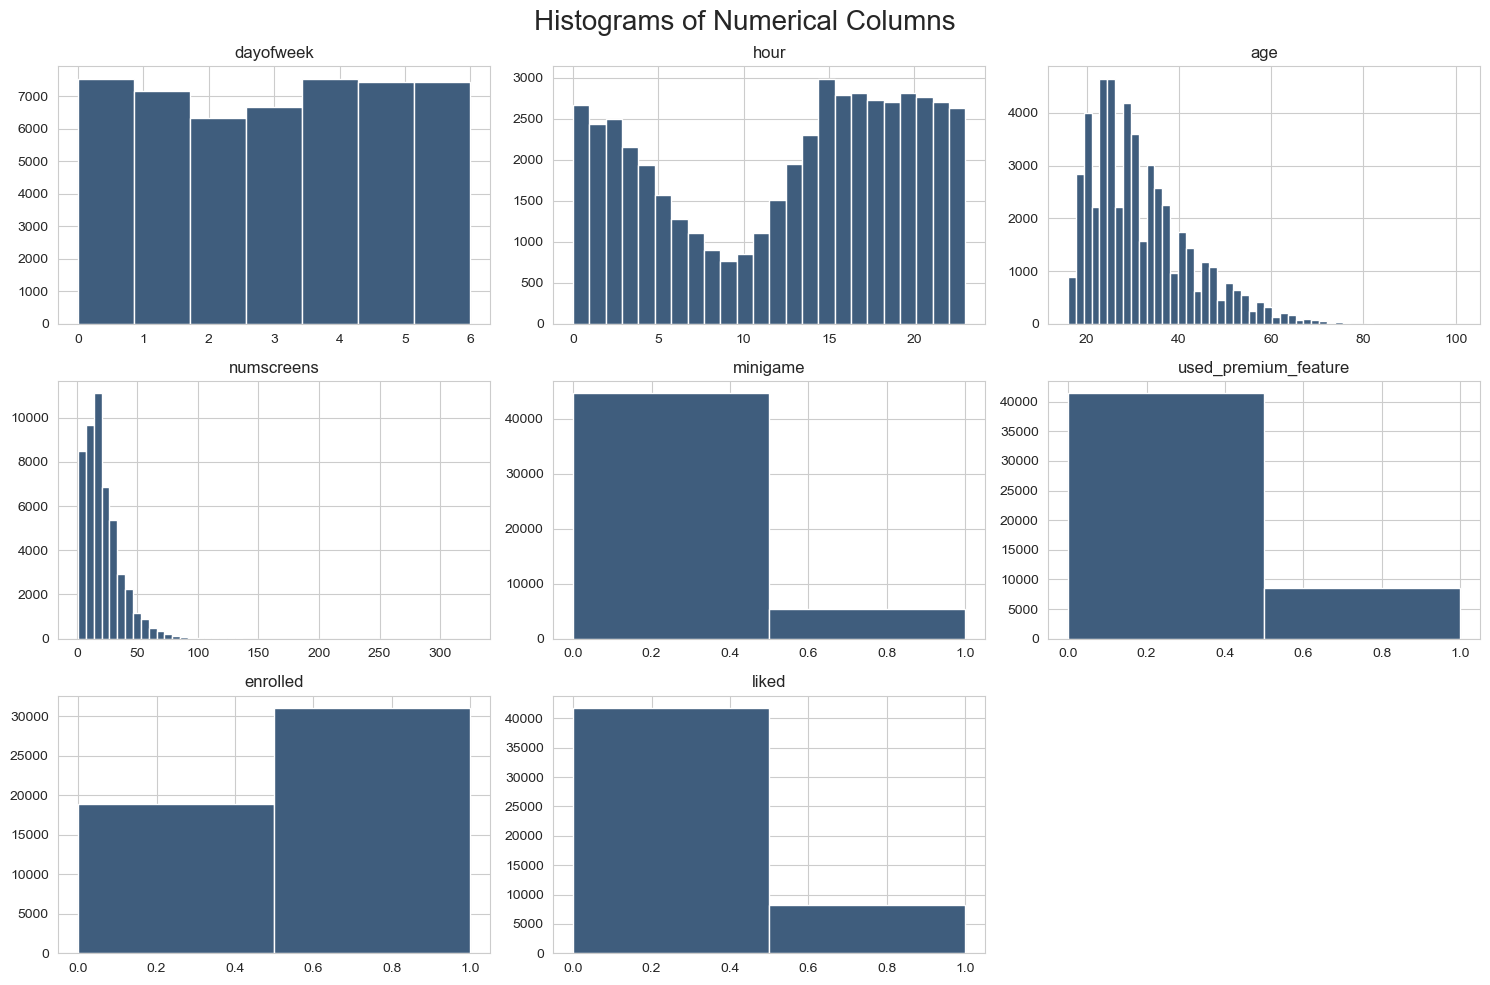

In [16]:
# Histograms of numerical columns
plt.figure(figsize=(15, 10))
plt.suptitle('Histograms of Numerical Columns', fontsize=20)
for i, col in enumerate(viz_data.columns):
    plt.subplot(3, 3, i+1)
    vals = len(viz_data[col].unique())
    plt.hist(viz_data[col], bins=min(vals, 50), color='#3F5D7D')
    plt.title(col)
plt.tight_layout()
plt.show()

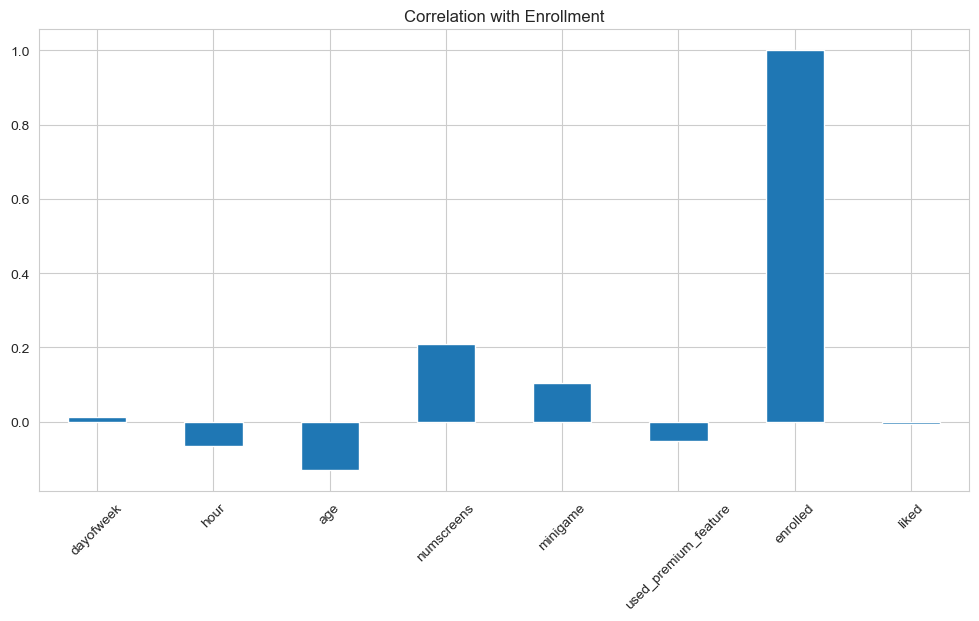

In [17]:
# Correlation with target variable
corr_with_target = viz_data.corrwith(dataset.enrolled)
corr_with_target.plot.bar(title='Correlation with Enrollment', figsize=(12, 6), rot=45)
plt.show()

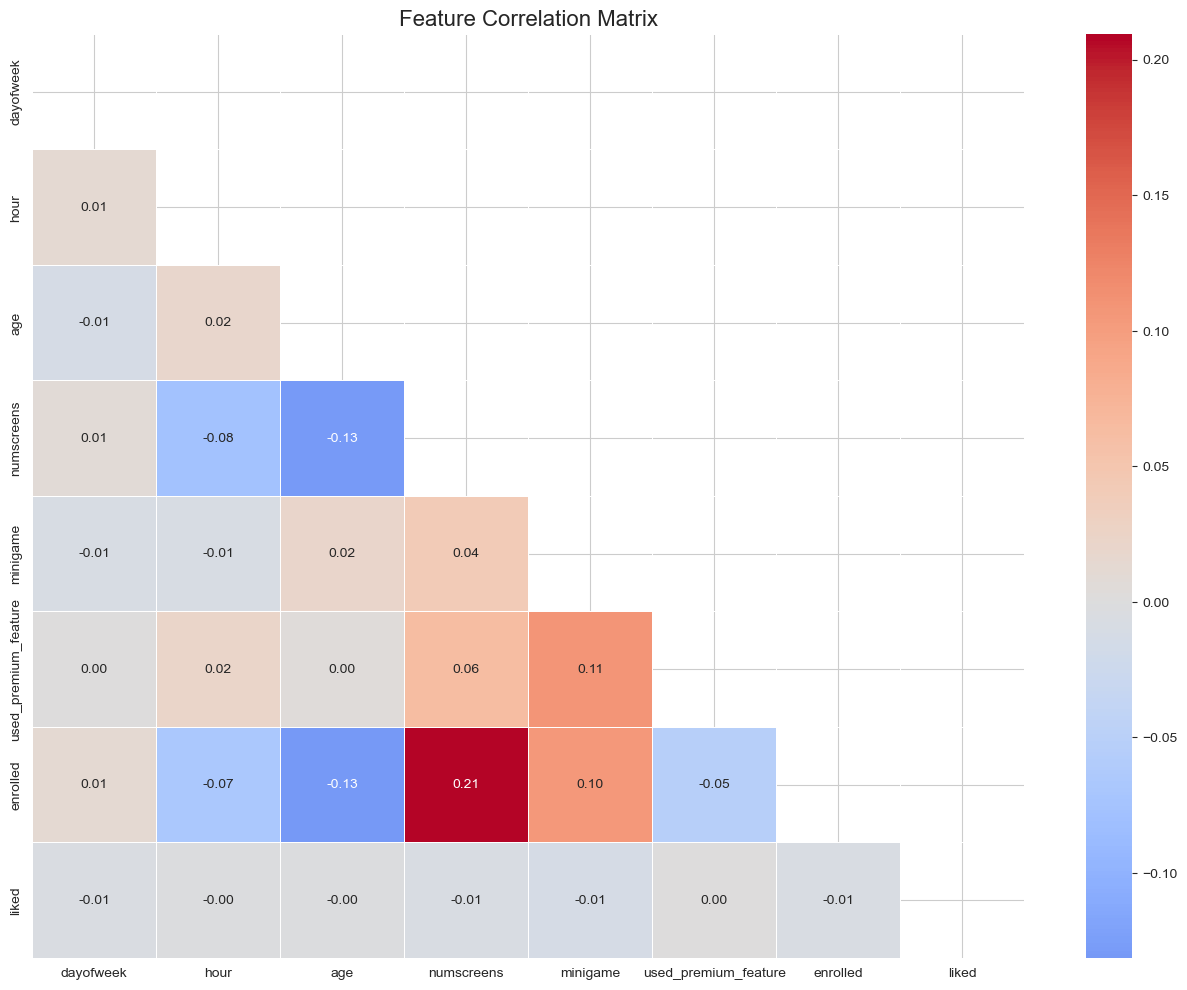

In [18]:
# Correlation matrix heatmap
corr_matrix = viz_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, annot=True, fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.show()


### 3. Feature Engineering


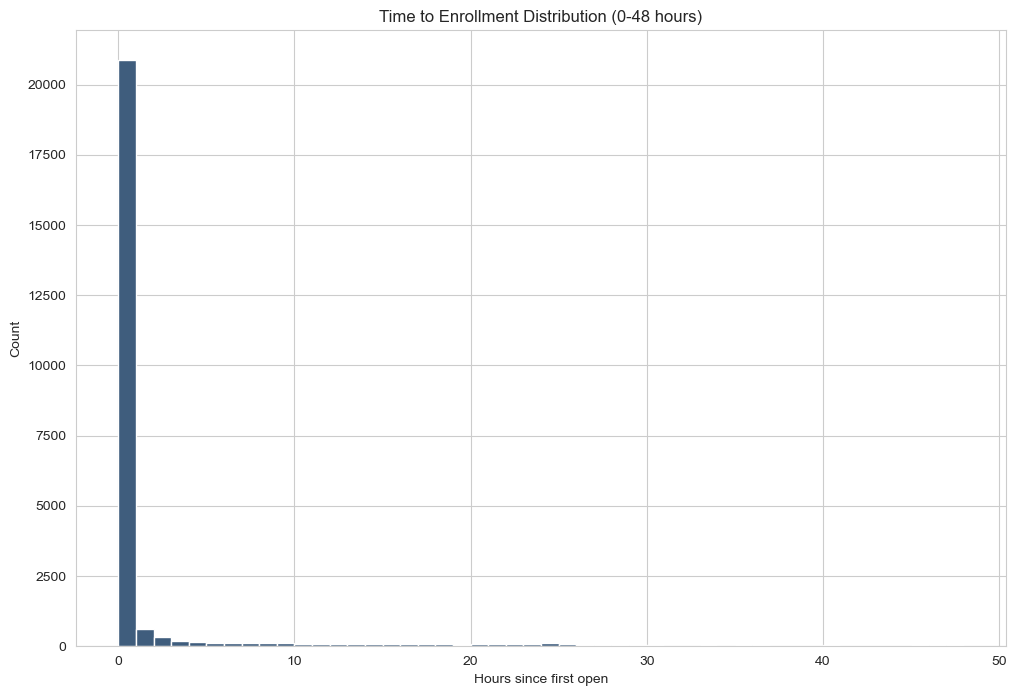

In [19]:
# Convert date columns to datetime
dataset["first_open"] = [parser.parse(d) for d in dataset["first_open"]]
dataset["enrolled_date"] = [parser.parse(d) if isinstance(d, str) else d for d in dataset["enrolled_date"]]

# Calculate time difference between first open and enrollment
dataset["time_to_enroll"] = (dataset.enrolled_date - dataset.first_open).dt.total_seconds() / 3600

# Visualize enrollment time distribution
plt.hist(dataset["time_to_enroll"].dropna(), bins=48, color='#3F5D7D', range=[0, 48])
plt.title('Time to Enrollment Distribution (0-48 hours)')
plt.xlabel('Hours since first open')
plt.ylabel('Count')
plt.show()

# Adjust enrollment target based on time threshold
dataset.loc[dataset.time_to_enroll > 48, 'enrolled'] = 0
dataset = dataset.drop(columns=['enrolled_date', 'time_to_enroll', 'first_open'])

# Process screen list features
top_screens = pd.read_csv('top_screens.csv').top_screens.values
dataset["screen_list"] = dataset.screen_list.astype(str) + ','
for screen in top_screens:
    dataset[screen] = dataset.screen_list.str.contains(screen).astype(int)
    dataset['screen_list'] = dataset.screen_list.str.replace(screen + ",", "")
dataset['other_screens'] = dataset.screen_list.str.count(",")
dataset = dataset.drop(columns=['screen_list'])

# Create screen category aggregates
screen_categories = {
    'savings': ["Saving1", "Saving2", "Saving2Amount", "Saving4", "Saving5", "Saving6", "Saving7", "Saving8", "Saving9", "Saving10"],
    'credit_monitoring': ["Credit1", "Credit2", "Credit3", "Credit3Container", "Credit3Dashboard"],
    'credit_cards': ["CC1", "CC1Category", "CC3"],
    'loans': ["Loan", "Loan2", "Loan3", "Loan4"]
}
for category, screens in screen_categories.items():
    dataset[f"{category}_count"] = dataset[screens].sum(axis=1)
    dataset = dataset.drop(columns=screens)

# Save processed data
dataset.to_csv('processed_appdata.csv', index=False)

### 4. Model Building and Evaluation


In [20]:
# Separate features and target
X = dataset.drop(columns=['enrolled', 'user'])
y = dataset['enrolled']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

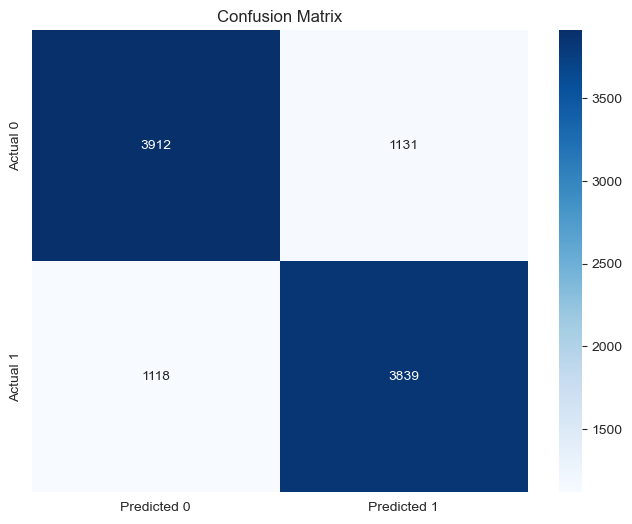

Model Metrics:
Accuracy: 0.7751
Precision: 0.7724
Recall: 0.7745
F1: 0.7734

Cross-Validation Accuracy: 0.7665 (+/- 0.0061)


In [21]:
# Initialize and train model
model = LogisticRegression(random_state=42, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred)
}

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Print results
print("Model Metrics:")
for name, value in metrics.items():
    print(f"{name.title()}: {value:.4f}")
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

### 5. Model Tuning

In [22]:
# Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Initialize model and grid search
model = LogisticRegression(random_state=42, solver='liblinear')
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Perform grid search
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Print results
print(f"\nGrid search completed in {end_time - start_time:.2f} seconds")
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Get best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Grid search completed in 11.31 seconds
Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best accuracy: 0.7668


### 6. Final Results and Analysis

In [23]:
# Create results dataframe
results = pd.DataFrame({
    'actual_enrollment': y_test,
    'predicted_enrollment': best_model.predict(X_test),
    'enrollment_probability': best_model.predict_proba(X_test)[:, 1]
})

# Save results
results.to_csv('enrollment_predictions.csv', index=False)

# Feature importance analysis
coefficients = pd.DataFrame({
    'feature': X_test.columns,
    'coefficient': best_model.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\nTop Positive Predictors:")
print(coefficients.head(10))
print("\nTop Negative Predictors:")
print(coefficients.tail(10))


Top Positive Predictors:
                    feature  coefficient
43            other_screens     0.900384
9               VerifyPhone     0.626204
45  credit_monitoring_count     0.565514
22             VerifyMobile     0.294344
15                 idscreen     0.159065
11        VerifyDateOfBirth     0.128950
23            VerifyHousing     0.085379
32       VerifyAnnualIncome     0.071191
10         BankVerification     0.049607
18              EditProfile     0.047605

Top Negative Predictors:
                    feature  coefficient
39              ResendToken    -0.076758
37                  WebView    -0.078802
36  ProfileEmploymentLength    -0.083692
35                    Login    -0.090397
3                numscreens    -0.096094
12              ProfilePage    -0.114765
2                       age    -0.143438
20                   Alerts    -0.224591
13            VerifyCountry    -0.299254
47              loans_count    -0.464440
